In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from fim import apriori

In [ ]:
df = pd.read_csv("/Users/alessandroincerti/Desktop/DM1/ravdess_dm1_2223/ravdess_features.csv",skipinitialspace=True)
df.head()

In [197]:
df_copy = df.copy()
df = df.drop(["modality","sample_width","channels","frame_rate",'mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min',
 'sc_max',
 'sc_kur',
 'sc_skew',
 'stft_mean',
 'stft_std',
 'stft_min',
 'stft_max',
 'stft_kur',
 'stft_skew',
 'mean',
 'std',
 'min',
 'max',
 'kur',
 'skew'],axis=1)

In [198]:
df_mod = df_copy.drop(["modality","statement","repetition", "actor","stft_max","channels","sample_width","frame_rate","frame_width"],axis=1)

In [5]:
# eliminiamo stft_max perchè assume solo un valore
#df_statistiche = df_copy[['mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min',
# 'sc_max',
# 'sc_kur',
# 'sc_skew',
# 'stft_mean',
# 'stft_std',
# 'stft_min',
# 'stft_kur',
# 'stft_skew',
# 'mean',
# 'std',
# 'min',
# 'max',
# 'kur',
# 'skew']]

### Data Understanding

In [6]:
#df["emotional_intensity"].isnull().any() False -> non ci sono missing values
a = df.groupby("emotional_intensity")["emotional_intensity"].count() #sarà la variabile target
b = df.groupby("emotional_intensity")["emotional_intensity"].count()/df.shape[0]
print(a, b)

emotional_intensity
normal    1320
strong    1132
Name: emotional_intensity, dtype: int64 emotional_intensity
normal    0.538336
strong    0.461664
Name: emotional_intensity, dtype: float64


###### Vogliamo mostrare i grafici relativi a: intensity, zero_crossings_sum, length_ms, frame_count, min, max e li vogliamo distiguere per emotional_intensity

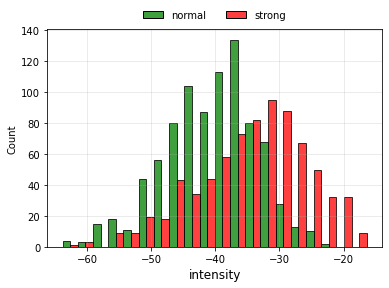

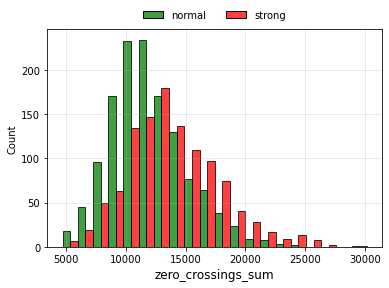

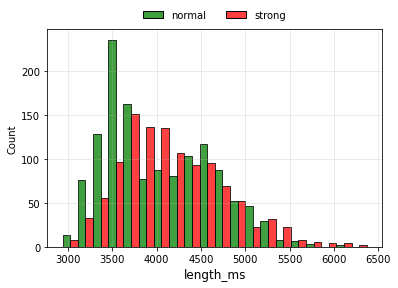

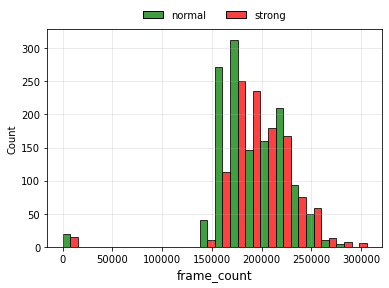

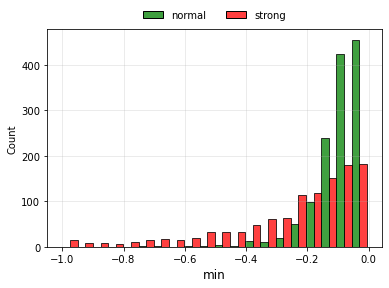

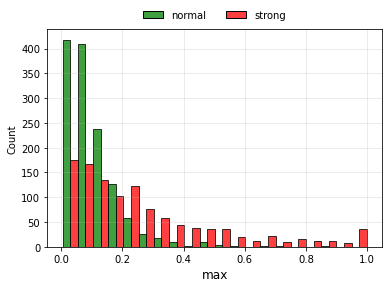

In [7]:
#Si potrebbe utilizzare la regola di Sturges per il numero di bin, però secondo me sono troppo grandi
#bins=int(np.log2(df.shape[0]))+1
variabili_per_ist = ["intensity", "zero_crossings_sum", "length_ms", "frame_count", "min", "max"]
for i in variabili_per_ist:
    graf = sns.histplot(data=df_copy, x=i, hue="emotional_intensity", bins=20, multiple="dodge",palette=['green', 'red'])
    plt.grid(alpha=0.3)
    sns.move_legend(graf, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.xlabel(i, fontsize=12)
    plt.show()

In [136]:
#Media e mediana per la variabile max (skewed a sinistra quindi la mediana è a sinistra della media)
print("Media: " + str(df_copy["max"].mean()) + "\nMediana: " + str(df_copy["max"].median()))

Media: 0.17983874364755298
Mediana: 0.109725953


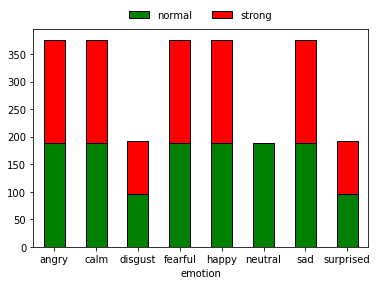

In [9]:
#in relazione alla variabile target
bar_pl = df["emotional_intensity"].groupby(df["emotion"]).value_counts().unstack(1).fillna(0)
bar_pl.plot(kind='bar',stacked=True, edgecolor='black',color=['green','red'])
plt.xticks(rotation=0)
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=3, frameon=False)
plt.show()

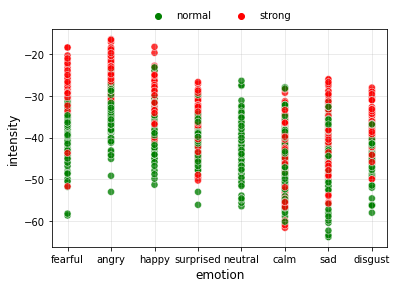

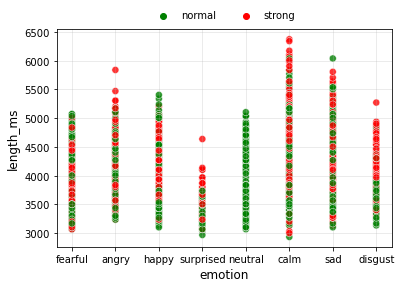

In [7]:
y = ["intensity", "length_ms"]
for i in y:
    graf = sns.scatterplot(data = df, x = "emotion", y = i, hue='emotional_intensity',palette=["green","red"],alpha=0.8,s=50)
    plt.grid(alpha=0.3)
    sns.move_legend(graf, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
    plt.xlabel("emotion", fontsize=12)
    plt.ylabel(i, fontsize=12)
    plt.show()

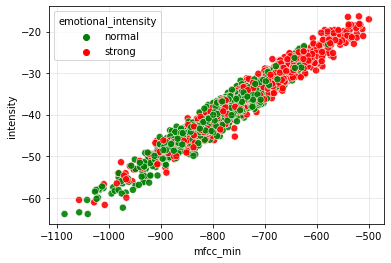

In [78]:
sns.scatterplot(data=df_copy, x="mfcc_min", y="intensity",hue='emotional_intensity',alpha=0.9,s=50,palette=["green","red"])#style='emotional_intensity',palette='Set2')
plt.grid(alpha=0.3)
plt.show()

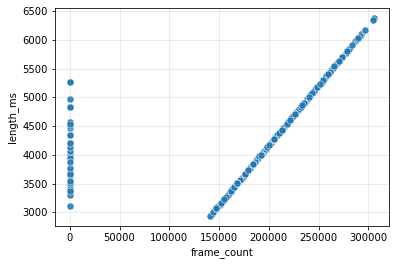

In [79]:
# Spiegazione per eliminare frame_count: errore nelle rilevazioni. Si passa da valore -1 a valore 140941. Inoltre studiandolo
# insieme a length_ms, notiamo che sembra esserci una correlazione lineare a meno dei valori "errati". Si passa da corr 0,73 a ...
sns.scatterplot(data=df, x="frame_count", y="length_ms",alpha=0.9,s=50)
plt.grid(alpha=0.3)
plt.show()

In [199]:
# ci sono 35 valori "errati" in frame_count. Li elimino
df_clean = df_copy[df_copy["frame_count"] > -1.0]

In [124]:
df_clean.shape[0]

2417

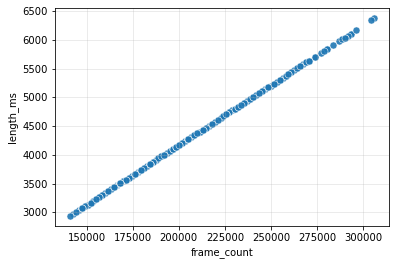

In [80]:
# Dopo la pulizia ecco che notiamo una forte correlazione positiva tra le due variabili, che sarà poi confermata dalla matrice di corr
sns.scatterplot(data=df_clean, x="frame_count", y="length_ms",alpha=0.9,s=50)
plt.grid(alpha=0.3)
plt.show()

Il nostro dataset è ora composto da 2417 righe. Proseguiamo con queste (quindi proseguo col dataset df_clean)

### Assessing Data Quality

MISSING VALUES

In [36]:
#Check dei missing values
for i in range(df_clean.shape[1]):
    if(df_clean.iloc[:,i].isnull().sum() == 0):
        pass
    else:
        print("Valori nulli di",df_clean.columns[i] + ":",df_clean.iloc[:,i].isnull().sum())

Valori nulli di vocal_channel: 193
Valori nulli di actor: 1107
Valori nulli di intensity: 805


In [37]:
df_clean.shape[0]

2417

Actor: Dal momento che quasi la metà delle righe ha valore null, conviene non utilizzare questa variabile, invece che cercare di rimpiazzare i valori. Il dataset è già piccolino per poter rimuovere una parte così grande dello stesso. Se il dataset fosse suff. grande potremmo eliminare il 45,8% dei null ed effettuare le analisi di corr sulla restante parte -> ma è piccolo (non è stat. significativa)

Vocal_channel: è una variabile categorica -> possiamo rimpiazzare i valori mancanti con la moda

Intensity: è una variabile continua e distribuzione simil gaussiana -> provando a sostituire i missing values con la mediana, o con il group by method (usando emotion e emotional_intensity), la distribuzione della variabile cambiava, quindi, data l'alta correlazione con la variabile mfcc_min, usiamo la regressione lineare

In [200]:
# Vocal channel: Rimpiazziamo con la moda
df_clean["vocal_channel_fixed"] = df_clean["vocal_channel"].fillna(df_clean["vocal_channel"].mode()[0])

C:\Users\scatau01\AppData\Local\Temp\ipykernel_9568\3624678855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["vocal_channel_fixed"] = df_clean["vocal_channel"].fillna(df_clean["vocal_channel"].mode()[0])


In [11]:
df_clean.groupby("vocal_channel")["vocal_channel"].count()

vocal_channel
song       907
speech    1317
Name: vocal_channel, dtype: int64

Voglio stimare i missing values di Intensity con una regressione lineare sulla variabile X = mfcc_min

In [42]:
df_clean["intensity"].isnull().sum()/df_clean.shape[0]
#i valori nulli di intensity sono il 33,3% del dataset: questi verranno considerati il test set, e tutto il resto il training set

0.3330575093090608

In [201]:
df_train_reg = df_clean[df_clean["intensity"].isnull() == False]
df_test_reg =  df_clean[df_clean["intensity"].isnull() == True]

x_train_reg = df_train_reg["mfcc_min"].values.reshape(-1,1)
y_train_reg = df_train_reg["intensity"].values

x_test_reg = df_test_reg["mfcc_min"].values.reshape(-1,1)
#y_test_reg saranno i missing values da determinare

In [202]:
reg = LinearRegression()
reg.fit(x_train_reg, y_train_reg)

LinearRegression()

In [203]:
a = reg.coef_
b = reg.intercept_
print("Coeff: ",a[0], "\nInterc: ",b)

Coeff:  0.08275078463276445 
Interc:  25.207684124611156


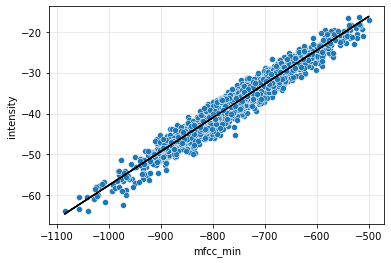

In [204]:
sns.scatterplot(data=df_clean, x="mfcc_min", y="intensity")
plt.plot(x_train_reg, a[0]*x_train_reg+b, c="black")
plt.grid(alpha=0.3)
plt.show()

In [205]:
y_pred_reg = reg.predict(x_train_reg)

# Stimiamo il modello
print("R^2: ", r2_score(y_train_reg, y_pred_reg))
print("MSE: ", mean_squared_error(y_train_reg, y_pred_reg))
print('MAE: ', mean_absolute_error(y_train_reg, y_pred_reg))

R^2:  0.9485948456280721
MSE:  3.6767567494682245
MAE:  1.5538100172097178


In [206]:
# I valori mancanti di intensity li stimiamo con la retta di regressione
y_test_reg = a[0]*x_test_reg+b

y_test_reg = y_test_reg.reshape(-1)

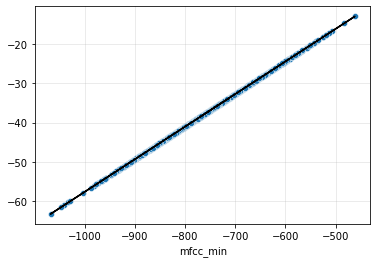

In [207]:
sns.scatterplot(x=df_test_reg["mfcc_min"], y=y_test_reg)
plt.plot(x_test_reg, a[0]*x_test_reg+b, c="black")
plt.grid(alpha=0.3)
plt.show()

In [208]:
#Nel test set, i valori mancanti di intensity vengono sostituiti da y_test_reg (valori stimati con regressione)
df_test_reg["intensity"] = y_test_reg

index_train = df_train_reg.index.tolist()
index_test = df_test_reg.index.tolist()
df_train_reg["index"] = index_train
df_test_reg["index"] = index_test

# Unisco i valori di training e test set e li ordino per indice in modo che siano ordinati come il set originario
df_clean = df_train_reg.merge(df_test_reg,how='outer')
df_clean = df_clean.sort_values(by=['index'])

C:\Users\scatau01\AppData\Local\Temp\ipykernel_9568\215938733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_reg["intensity"] = y_test_reg
C:\Users\scatau01\AppData\Local\Temp\ipykernel_9568\215938733.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_reg["index"] = index_train
C:\Users\scatau01\AppData\Local\Temp\ipykernel_9568\215938733.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

<AxesSubplot:xlabel='intensity', ylabel='Count'>

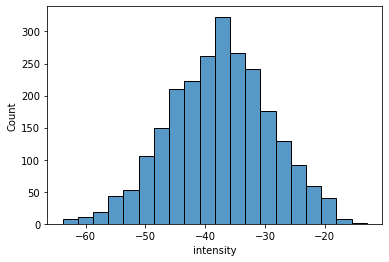

In [20]:
# Istogramma di intensity sistemato
sns.histplot(data=df_clean, x="intensity", bins=20, multiple="dodge")

<AxesSubplot:xlabel='intensity', ylabel='Count'>

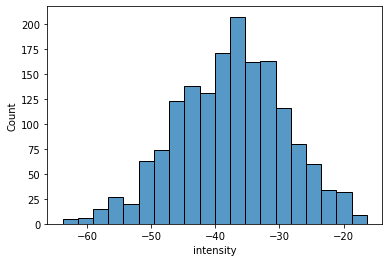

In [21]:
# Istogramma intensity originario, abbiamo "migliorato" la distribuzione
sns.histplot(data=df_copy, x="intensity", bins=20, multiple="dodge")

VARIABILI "INUTILI"

Modality, sample_width, frame_rate, stft_max assumono solo un valore -> sono inutili ai fini dell'analisi e quindi eliminiamo queste variabili.

Inoltre frame_width e channels sono strettamente correlate (corr=1), quando frame_width è 2, channels e 1 e quando frame_width è 4, channels è 2 (come dimostrato dal grafico seguente) -> eliminiamo la variabile frame_with (in quanto channels è più comprensibile)

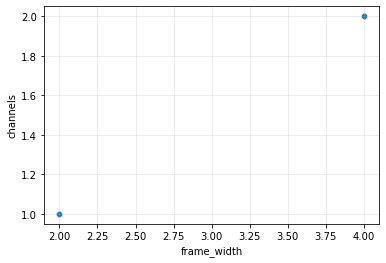

In [167]:
sns.scatterplot(data=df_clean, x="frame_width", y="channels")
plt.grid(alpha=0.3)
plt.show()

In [209]:
df_clean = df_clean.drop(["modality","sample_width","frame_rate","frame_width","stft_max","index"],axis=1)

OUTLIERS

In [21]:
# standardizziamo le variabili continue per vederle sulla stessa scala 
df_train_norm = df_clean.drop(["channels",'vocal_channel',"actor",'emotion','emotional_intensity','statement',
                              'repetition','sex','vocal_channel_fixed',"actor"],axis=1)

In [22]:
scaler = StandardScaler()
df_zscore = scaler.fit_transform(df_train_norm)

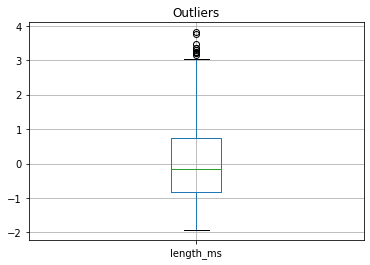

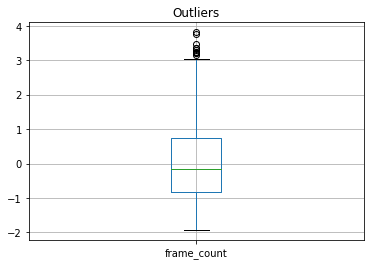

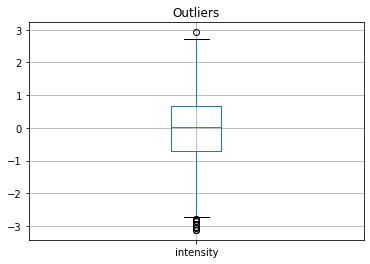

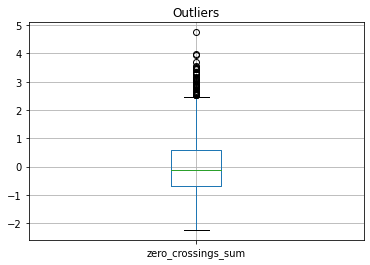

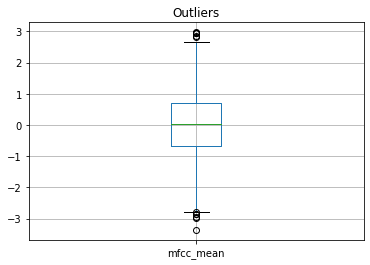

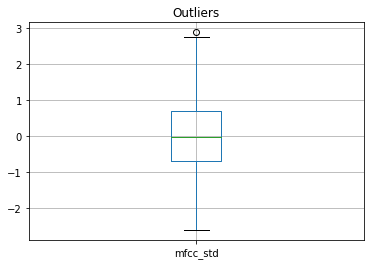

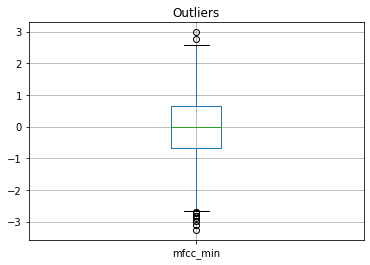

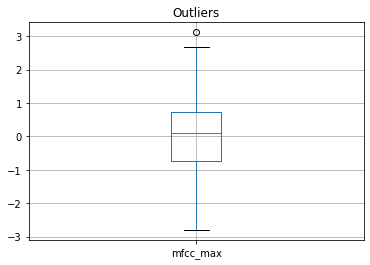

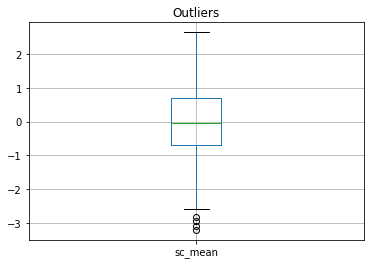

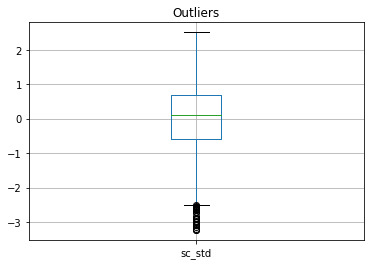

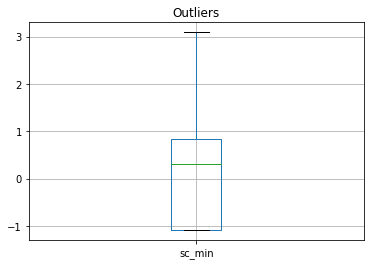

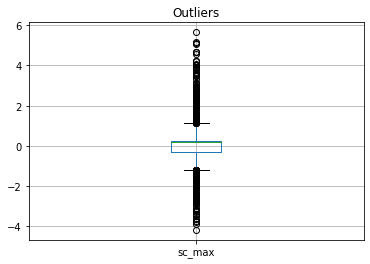

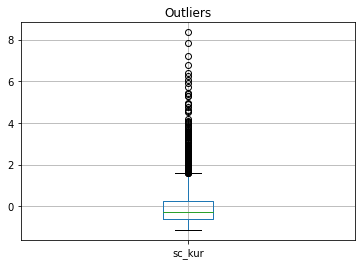

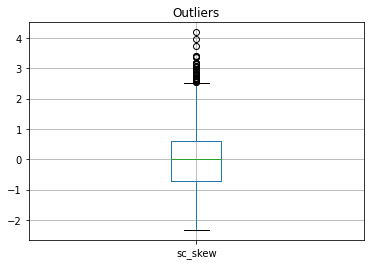

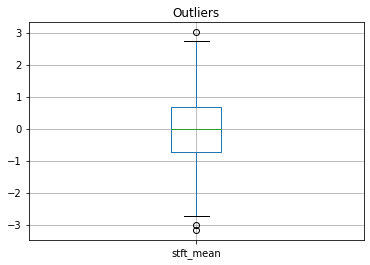

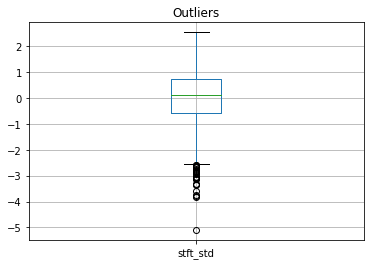

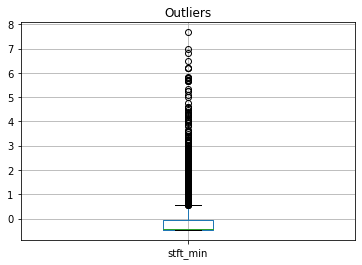

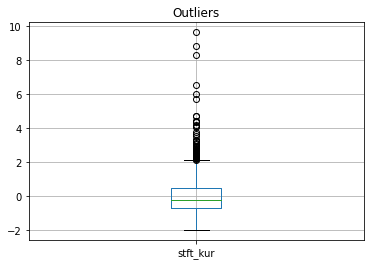

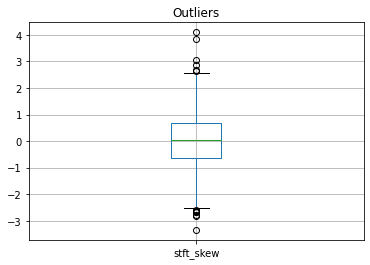

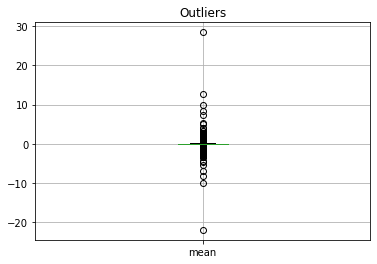

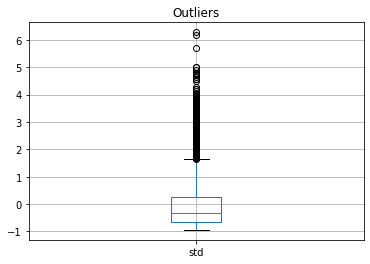

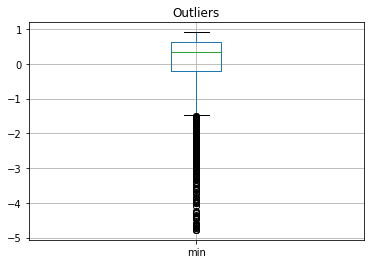

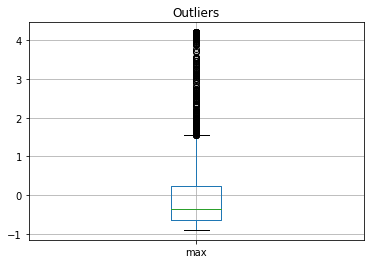

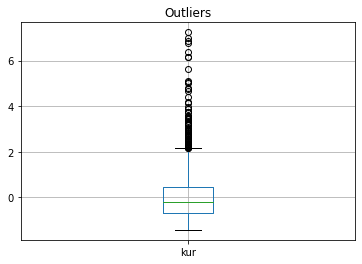

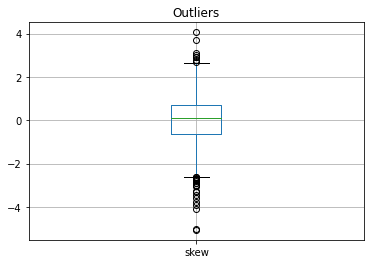

In [55]:
column_names = list(df_train_norm.columns)
df_zscore_pd = pd.DataFrame(df_zscore,columns=column_names)
for i in column_names:
    df_zscore_pd.boxplot(column=i)
    plt.title("Outliers")
    plt.show()

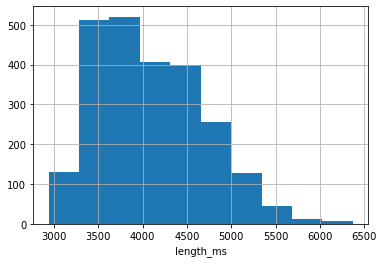

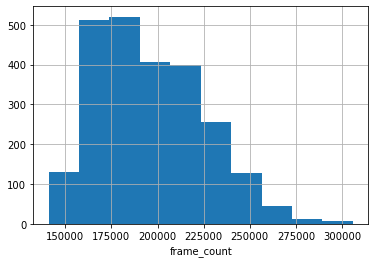

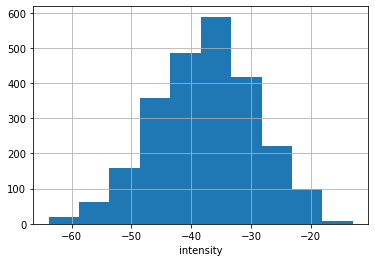

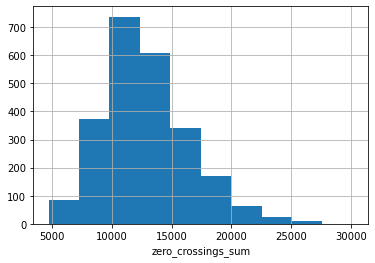

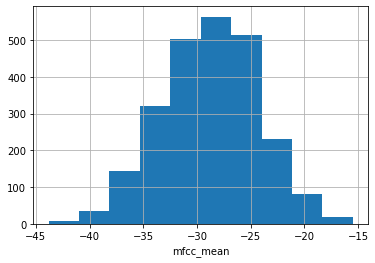

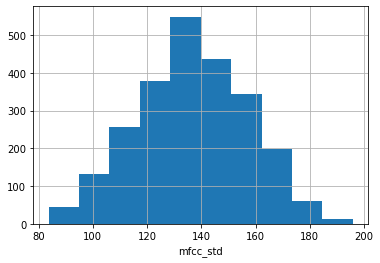

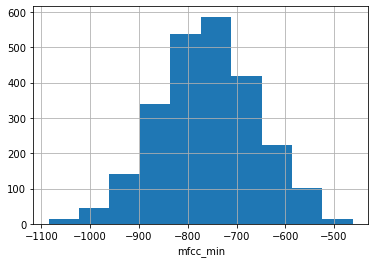

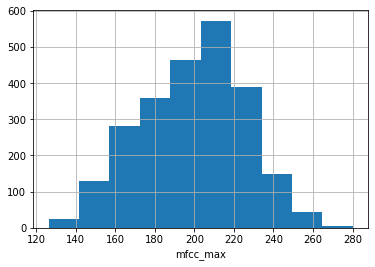

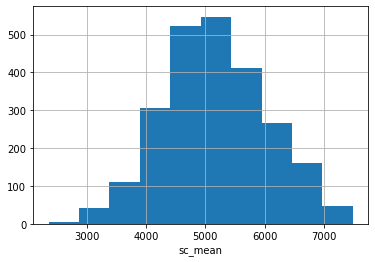

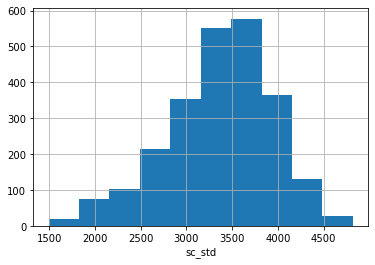

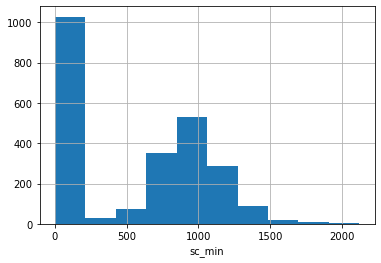

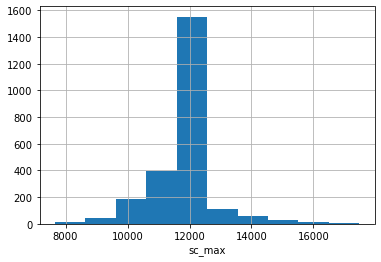

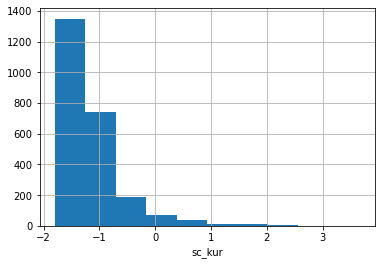

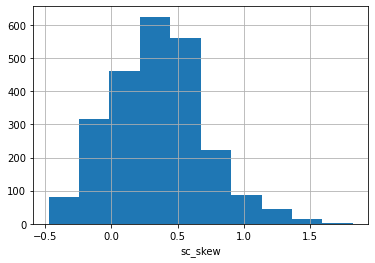

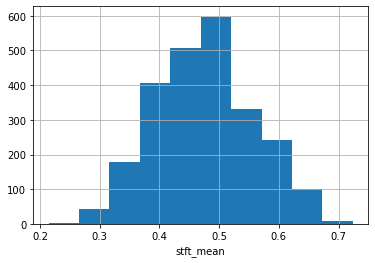

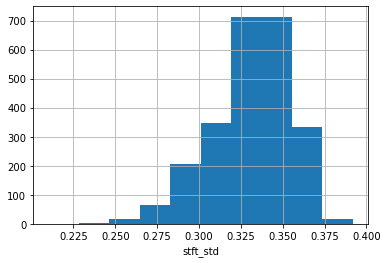

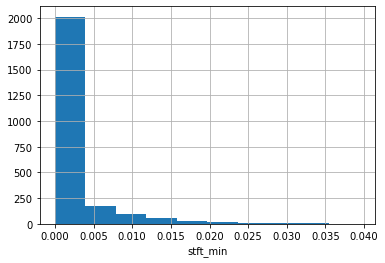

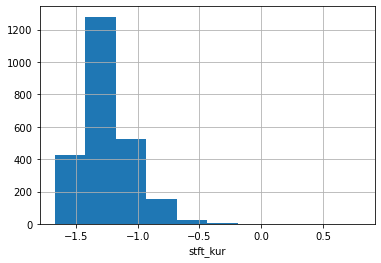

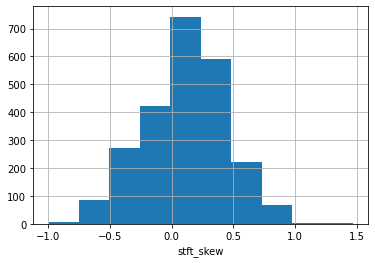

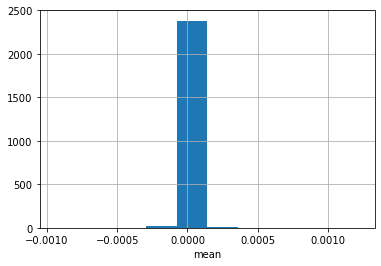

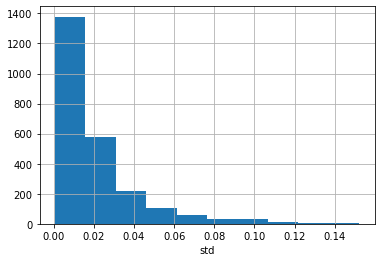

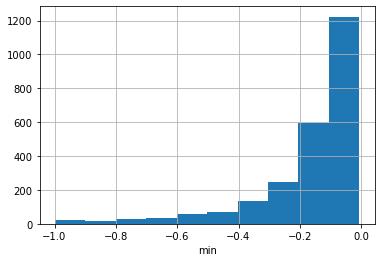

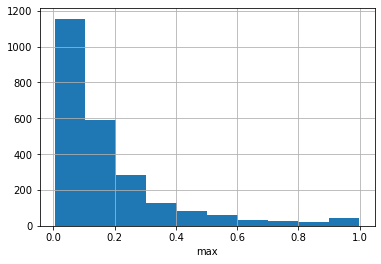

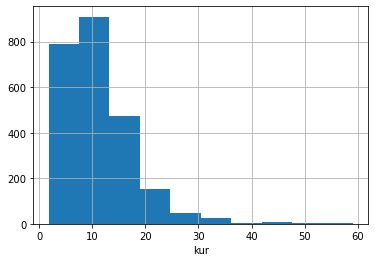

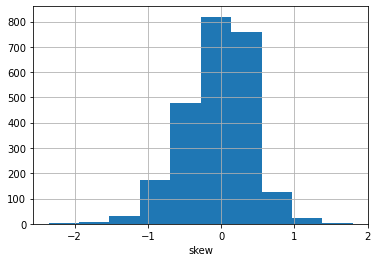

In [56]:
for i in column_names:
    df_clean.loc[:,i].hist()
    plt.xlabel(i)
    plt.show()

Non eliminerei i valori sopra le "scatole" perchè rappresentano la coda delle distribuzioni

### Variable Transformation

Rendiamo numeriche le variabili emotion, vocal_channel_fixed, sex

In [210]:
emotion_d = sorted(df_clean["emotion"].unique())
emotion_d_map = dict(zip(emotion_d, range(len(emotion_d))))
df_clean["emotion_d"] = df_clean["emotion"].map(emotion_d_map)

In [211]:
vocal_channel_d = sorted(df_clean["vocal_channel_fixed"].unique())
vocal_channel_d_map = dict(zip(vocal_channel_d, range(len(vocal_channel_d))))
df_clean["vocal_channel_d"] = df_clean["vocal_channel_fixed"].map(vocal_channel_d_map)

In [212]:
sexes = sorted(df_clean["sex"].unique())
sexes_new = dict(zip(sexes,range(len(sexes))))
df_clean["sex_b"] = df_clean["sex"].map(sexes_new)

### Correlazione

La variabile channels è quasi sempre 1 (solo in 6 righe assume valore 2). La escludiamo

In [26]:
df_clean_corr = df_clean.drop(["vocal_channel","repetition","channels","emotional_intensity","statement","vocal_channel_fixed","sex","actor","emotion"],axis=1)

- length_ms e frame_count hanno correlazione = 1 -> eliminiamo frame_count
- intensity e mfcc_min (come visto prima) hanno alta correlazione (= 0.98) -> eliminiamo mfcc_min
- intensity e mfcc_std hanno alta corr negativa (-0.98) -> eliminiamo mfcc_std
- stft_mean e stft_skew hanno alta corr negativa (-0.97) -> eliminiamo stft_skew
- std, min e max hanno alta correlazione tra loro -> eliminiamo std e min

Variabili da eliminare: 
frame_count, mfcc_min, mfcc_std, stft_skew, std, min

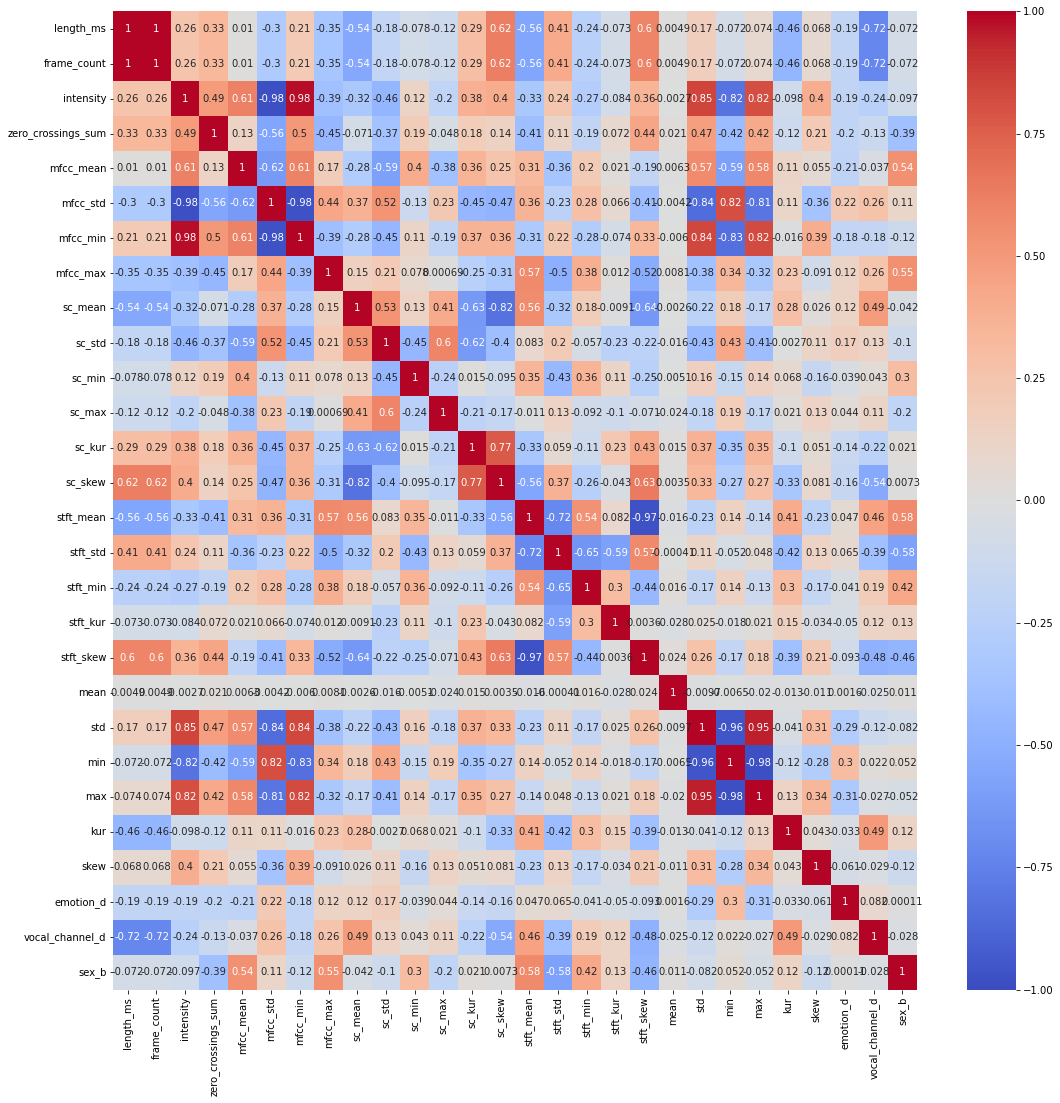

In [264]:
plt.figure(figsize=(18,18))
sns.heatmap(df_clean_corr.corr(),cmap='coolwarm',annot=True,vmin=-1,vmax=1)
plt.show()

Ricalcoliamo la correlazione con le variabili escluse

In [265]:
df_clean_corr_2 = df_clean_corr.drop(["frame_count", "mfcc_min", "mfcc_std", "stft_skew", "std", "min"],axis=1)

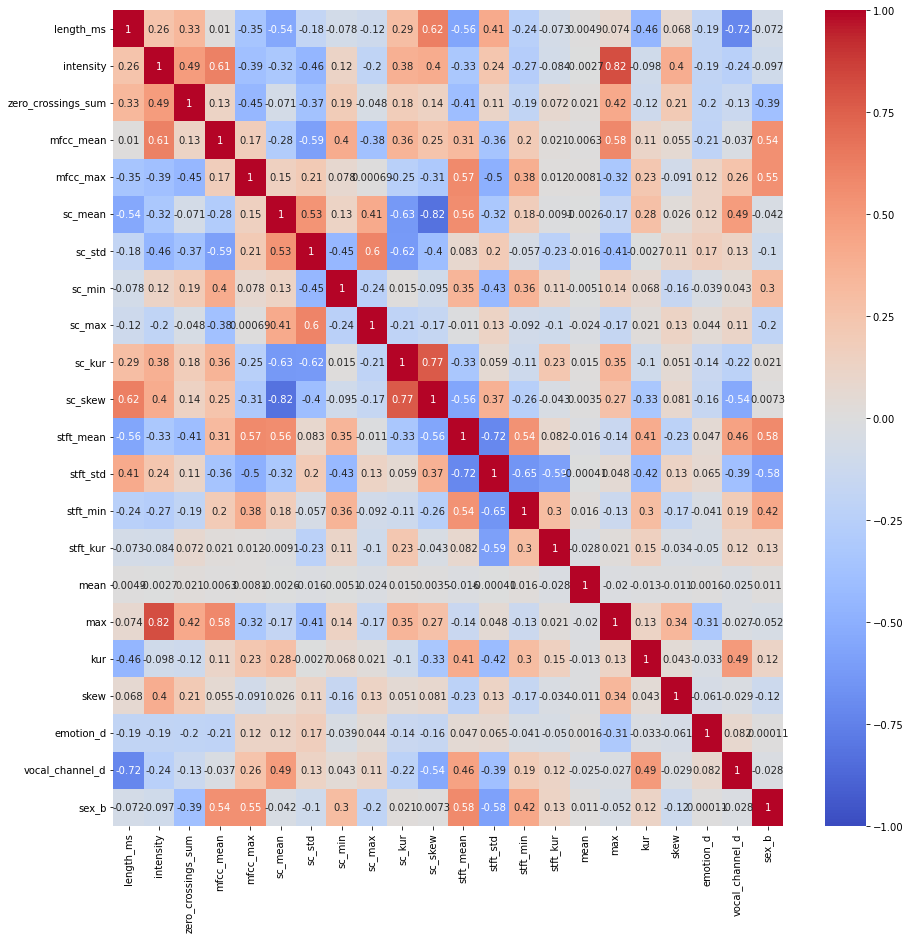

In [266]:
plt.figure(figsize=(15,15))
sns.heatmap(df_clean_corr_2.corr(),cmap='coolwarm',annot=True,vmin=-1,vmax=1)
plt.show()

### Clustering: Kmeans

Dal momento che abbiamo 22 variabili rimanenti, proviamo a comporre vari dataset (sottoinsiemi del precedente) per capire su quale funziona meglio il kmeans

In [28]:
# bisogna decidere che variabili vogliamo tenere per il clustering
df_train_clustering = df_clean.drop(["actor","sex_b","sex","channels","emotion","emotional_intensity","repetition","statement",
                                    "frame_count", "mfcc_min", "mfcc_std", "stft_skew", "std", "min","vocal_channel_fixed",
                                    "vocal_channel","emotion_d","vocal_channel_d"],axis=1)

# Num cluster, 3,4,5 cluster -> abbastanza uguale
# SSE: 614.23
# Silhouette: 0.177

In [30]:
df_train_prova = df_clean.drop(["actor","sex_b","sex","channels","emotion","emotional_intensity","repetition","statement",
                                "frame_count", "mfcc_min", "mfcc_std", "stft_skew", "std", "min","vocal_channel_fixed",
                                "vocal_channel","emotion_d","vocal_channel_d",'mfcc_mean','mfcc_max','sc_mean',
                                'sc_std','sc_min','sc_max','sc_kur','sc_skew','stft_mean','stft_std','stft_min','stft_kur'],axis=1)

# Num cluster, 3,4,5 cluster -> abbastanza uguale
# SSE: 152.68
# Silhouette: 0.25

In [670]:
list(df_train_prova.columns)

['length_ms', 'intensity', 'zero_crossings_sum', 'mean', 'max', 'kur', 'skew']

In [708]:
df_train_prova_1 = df_clean.drop(["actor","sex_b","sex","channels","emotion","emotional_intensity","repetition","statement",
                                  "frame_count", "mfcc_min", "mfcc_std", "stft_skew", "std", "min","vocal_channel_fixed",
                                  "vocal_channel","emotion_d","vocal_channel_d",'mfcc_mean','mfcc_max','sc_mean',
                                  'sc_std','sc_min','sc_max','sc_kur','sc_skew','stft_mean','stft_std','stft_min','stft_kur',
                                  "mean","kur"],axis=1)

## Num cluster, 3,4,5 cluster -> abbastanza uguale
# SSE: 121.85
# Silhouette: 0.23

In [707]:
list(df_train_prova_1.columns)

['length_ms', 'intensity', 'zero_crossings_sum', 'max', 'skew', 'label']

In [32]:
df_train_prova_2 = df_clean.drop(["actor","sex_b","sex","channels","emotion","emotional_intensity","repetition","statement",
                                  "frame_count", "mfcc_min", "mfcc_std", "stft_skew", "std", "min","vocal_channel_fixed",
                                  "vocal_channel","emotion_d","vocal_channel_d",'mfcc_mean','mfcc_max','sc_mean',
                                  'sc_std','sc_min','sc_max','sc_kur','sc_skew','stft_mean','stft_std','stft_min','stft_kur',
                                  'max','mean', 'kur', 'skew'],axis=1)

# rimangono solo length_ms, intensity, 'zero_crossings_sum'
# 4,5 cluster
# SSE: 72.13
# Silhouette: 0.299

In [33]:
df_train_prova_3 = df_clean.drop(["actor","sex","channels","emotion","emotional_intensity","repetition","statement",
                                  "frame_count", "mfcc_min", "mfcc_std", "stft_skew", "std", "min","vocal_channel_fixed",
                                  "vocal_channel",'mfcc_mean','mfcc_max','sc_mean','sc_std','sc_min','sc_max',
                                  'sc_kur','sc_skew','stft_mean','stft_std','stft_min','stft_kur','max','mean','kur','skew'],axis=1)

# rimangono solo length_ms, intensity, zero_crossings_sum, sex_d, emotion_d, vocal_channel_d
# Best Trade-off: 4 cluster
# SSE: 386.34
# Silhouette: 0.55

In [39]:
df_train_prova_4 = df_clean.drop(["actor","sex","channels","emotion","emotional_intensity","repetition","statement",
                                  "frame_count", "mfcc_min", "mfcc_std", "stft_skew", "std", "min","vocal_channel_fixed",
                                  "vocal_channel",'mfcc_mean','mfcc_max','sc_mean','sc_std','sc_min','sc_max',
                                  'sc_kur','sc_skew','stft_mean','stft_std','stft_min','stft_kur','max','mean','kur','skew',
                                  "emotion_d"],axis=1)

# rimangono solo length_ms, intensity, zero_crossings_sum, sex_b, vocal_channel_d
# Best Trade-off: 4 cluster
# SSE: 136.34
# Silhouette: 0.718

In [709]:
scaler1 = MinMaxScaler()
df_minmax = scaler1.fit_transform(df_train_prova_1)

In [92]:
list(df_train_prova_2.columns)

['length_ms', 'intensity', 'zero_crossings_sum']

In [700]:
sse = []
for k in range(1,23):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, init="k-means++")
    kmeans.fit(df_minmax)
    sse.append(kmeans.inertia_)

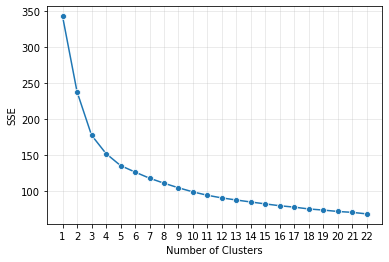

In [701]:
sns.lineplot(x = range(1,23), y = sse, marker = 'o')
plt.xlabel("Number of Clusters")
plt.xticks(range(1,23,1))
plt.ylabel("SSE")
plt.grid(alpha=0.3)
plt.show()

In [710]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=300, init="k-means++",random_state=0)
kmeans.fit(df_minmax)

KMeans(n_clusters=4, random_state=0)

In [711]:
print(silhouette_score(df_minmax, kmeans.labels_),kmeans.inertia_)

0.2615175841043923 127.30918470992337


In [712]:
# aggiungiamo l'etichetta del cluster al dataframe
df_clean["label"] = kmeans.labels_

In [713]:
# Distribuzione dei cluster
round(df_clean["label"].value_counts()/df_clean.shape[0],3)

3    0.315
2    0.294
0    0.282
1    0.110
Name: label, dtype: float64

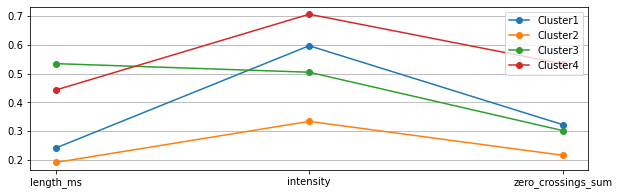

In [687]:
# visualizziamo i centroidi
centers = kmeans.cluster_centers_
#centers = scaler1.inverse_transform(centers)
plt.figure(figsize=(10, 3))

clust_name = ['Cluster1', 'Cluster2', 'Cluster3' , 'Cluster4']
for i in range(len(centers)):
    plt.plot(centers[i], marker='o', label=clust_name[i])
    
plt.xticks(range(0,len(df_train_prova_2.columns)), df_train_prova_2.columns, fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=10, loc='best')
plt.grid(axis='y')

In [688]:
# mi serve lavorare con il dataset normalizzato
df_minmax_tab = pd.DataFrame(df_minmax, columns = list(df_train_prova_2.columns))
df_minmax_tab["label"] = kmeans.labels_
df_minmax_tab

,length_ms,intensity,zero_crossings_sum,label
0,0.233052,0.532021,0.482620,0
1,0.281641,0.589372,0.361159,0
2,0.504801,0.620511,0.550566,3
3,0.203957,0.291739,0.271154,1
4,0.427117,0.641662,0.409563,3
...,...,...,...,...
2412,0.485598,0.358541,0.202501,2
2413,0.359325,0.403306,0.166798,1
2414,0.670061,0.500936,0.198333,2
2415,0.233052,0.355975,0.196406,1


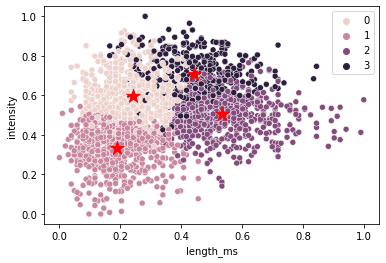

In [693]:
sns.scatterplot(data=df_minmax_tab, x="length_ms", y="intensity", hue='label', hue_order=["Cluster1", "Cluster2", "Cluster3", "Cluster4"])
plt.legend()
plt.scatter(centers[:,0], centers[:,1], c='red', marker='*', s=200)
plt.show()

Vediamo come sono distribuite alcune variabili nei vari cluster

Escludiamo sex

In [ ]:
list_plot = ["emotional_intensity","sex", "vocal_channel_fixed","emotion"]
for i in list_plot:
    bar_pl = df_clean[i].groupby(df_clean['label']).value_counts(normalize=True).unstack(1)
    if i == "emotional_intensity":
        bar_pl.plot(kind='bar', stacked=True, edgecolor='black', linewidth=1, color=['green', 'red'])
    else:
        bar_pl.plot(kind='bar', stacked=True, edgecolor='black', linewidth=1)#, color=['green', 'red'])
    plt.xticks(range(0, len(clust_name)), clust_name, fontsize=10, rotation=0)
    plt.yticks(fontsize=10)
    plt.legend(loc="lower center",bbox_to_anchor=(.5, 1), ncol=3, frameon=False)
    plt.show()

In [ ]:
### Clustering: DBScan

In [344]:
dist = pdist(df_minmax, 'euclidean')
dist = squareform(dist)

In [298]:
#k=6
#kth_distances = []
#for d in dist:  # d is a vector containing distances between the ith record and all the others
#    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
#    kth_distances.append(d[index_kth_distance])  # store the distance in a list

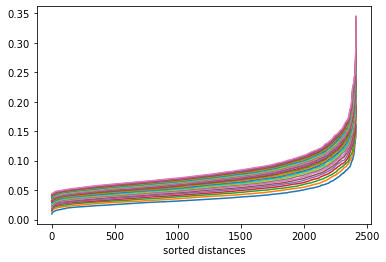

In [345]:
n = list(range(3,30))
for i in n:
    nth_distances[i] = []
    for d in dist:
        index_nth_distance = np.argsort(d)[i]
        nth_distances[i].append(d[index_nth_distance])
    plt.plot(range(0, len(nth_distances[i])), sorted(nth_distances[i]))
    plt.xlabel("sorted distances")

In [608]:
for i in range(5,11):
    for j in range(3,30):
        dbscan = DBSCAN(eps=i*0.01, min_samples=j, metric='euclidean')
        dbscan.fit(df_minmax)
        hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))
        if silhouette_score(df_minmax, dbscan.labels_) > 0.1 and hist[0]<30:
            print("eps: ", i*0.01, "min_samples: ", j, "silhouette: ", silhouette_score(df_minmax, dbscan.labels_), 
                  "n_outliers: ", hist[0])

eps:  0.09 min_samples:  3 silhouette:  0.21949777083718564 n_outliers:  17
eps:  0.09 min_samples:  4 silhouette:  0.2195076583659769 n_outliers:  21
eps:  0.1 min_samples:  3 silhouette:  0.219307068808902 n_outliers:  8
eps:  0.1 min_samples:  4 silhouette:  0.22245774699789686 n_outliers:  10
eps:  0.1 min_samples:  5 silhouette:  0.39579556315309655 n_outliers:  21
eps:  0.1 min_samples:  6 silhouette:  0.39579556315309655 n_outliers:  21
eps:  0.1 min_samples:  7 silhouette:  0.398723726428032 n_outliers:  27


Valori finali:
eps:  0.1 min_samples:  5 silhouette:  0.39579556315309655 n_outliers:  21

a parità di eps, diminuenndo il numero di outliers andremmo a dimezzare (quasi) la silhouette

In [655]:
dbscan = DBSCAN(eps=0.1, min_samples=5, metric='euclidean')
dbscan.fit(df_minmax)

DBSCAN(eps=0.09, min_samples=10)

In [656]:
hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df_minmax, dbscan.labels_))

labels {-1: 86, 0: 2331, 1: 0}
silhouette 0.3611894403822728


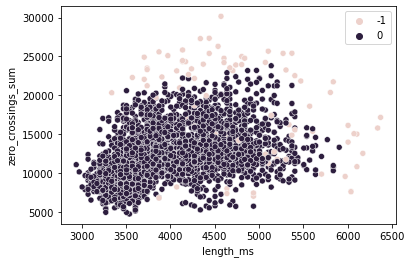

In [657]:
sns.scatterplot(data=df_clean, x="length_ms", y="zero_crossings_sum", hue=dbscan.labels_)
plt.show()

Conclusioni:
- essendo l'area molto densa ogni punto può facilmente raggiungere l'altro, quindi si crea un cluster unico molto grande e qualche outliers sparso
- plottiamo una tabellina con valori di eps, min_sample, silhouette, dimensione dei cluster
- per il nostro set di dati, il dbscan non risulta un buon modello di clustering

### Clustering: Hierarchical

In [370]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [420]:
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model_complete = model_complete.fit(df_minmax)

model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model_single = model_single.fit(df_minmax)

model_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model_avg = model_avg.fit(df_minmax)

model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model_ward = model_ward.fit(df_minmax)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)


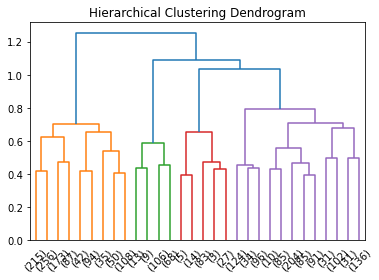

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)


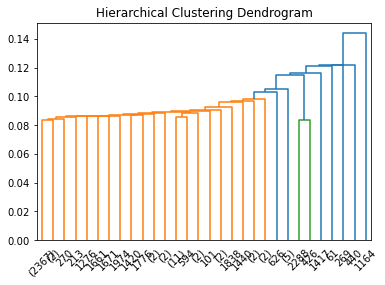

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)


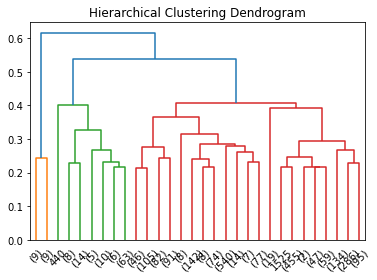

AgglomerativeClustering(distance_threshold=0, n_clusters=None)


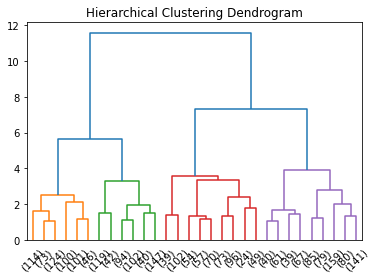

In [414]:
type_of_model = [model_complete, model_single, model_avg, model_ward]
for i in type_of_model:
    plt.title("Hierarchical Clustering Dendrogram")
    if i == model_ward:
        plot_dendrogram(i, truncate_mode="lastp", color_threshold=5)
    else:
        plot_dendrogram(i, truncate_mode="lastp")
    print(i)
    plt.show()

In [411]:
hier_complete = AgglomerativeClustering( n_clusters=4, affinity='euclidean', linkage='complete')
hier_complete = hier_complete.fit(df_minmax)

hier_single = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single')
hier_single = hier_single.fit(df_minmax)

hier_avg = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
hier_avg = hier_avg.fit(df_minmax)

hier_ward = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hier_ward = hier_ward.fit(df_minmax)

In [412]:
different_model = [hier_complete, hier_single, hier_avg, hier_ward]
for i in different_model:
    hist, bins = np.histogram(i.labels_, bins=range(0, len(set(i.labels_)) + 1))
    print(i)
    print('labels', dict(zip(bins, hist)))
    print('silhouette', silhouette_score(df_minmax, i.labels_))
    print('\n')

AgglomerativeClustering(linkage='complete', n_clusters=4)
labels {0: 1029, 1: 1060, 2: 196, 3: 132}
silhouette 0.23119214400649693


AgglomerativeClustering(linkage='single', n_clusters=4)
labels {0: 2414, 1: 1, 2: 1, 3: 1}
silhouette 0.25799262289397895


AgglomerativeClustering(linkage='average', n_clusters=4)
labels {0: 107, 1: 1194, 2: 1098, 3: 18}
silhouette 0.2505659823028556


AgglomerativeClustering(n_clusters=4)
labels {0: 751, 1: 544, 2: 564, 3: 558}
silhouette 0.2417831658734131




Conclusioni:
- Silhouette score molto simili tra di loro
- Proporzione di punti nei cluster migliore per ward (anche se un po' diverse dal kmeans)

In [417]:
print('% ward', dict(zip(bins, hist/df_clean.shape[0])))

% ward {0: 0.3107157633429872, 1: 0.22507240380637153, 2: 0.23334712453454695, 3: 0.23086470831609432}


In [659]:
df_minmax_tab["label_ward"] = hier_ward.labels_

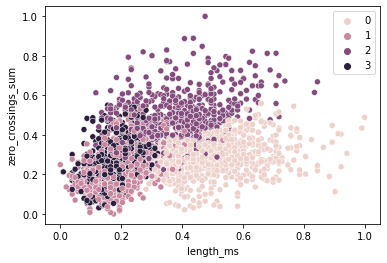

In [669]:
sns.scatterplot(data=df_minmax_tab, x="length_ms", y="zero_crossings_sum", hue='label_ward', hue_order=["Cluster1", "Cluster2", "Cluster3", "Cluster4"])
plt.legend()

Conclusioni clustering: 
- plottando length_ms e intensity, viene meglio il kmeans
- con le latre combinazioni bruttini entrambi

### Classification

Usiamo le 3 variabili usate per il clustering e aggiungiamo:
- emotion
- vocal channel
- sex

Vanno rese binarie con apposito preprocessing

In [213]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_clean['emotional_intensity'].values[:5]

df_clean['emotional_intensity_b'] = le.fit_transform(df_clean['emotional_intensity'])
df_clean['emotional_intensity_b']

0       0
1612    0
1       1
2       0
3       1
       ..
2415    1
1609    0
2416    1
1610    0
1611    0
Name: emotional_intensity_b, Length: 2417, dtype: int32

normal è 0

In [501]:
categorical_cols = ["emotion"]

df_classif = pd.get_dummies(df_clean, columns=categorical_cols)
df_classif["emozioni_controllate"] = df_classif["emotion_calm"] + df_classif["emotion_neutral"] + df_classif["emotion_sad"] + df_classif["emotion_happy"]
df_classif["emozioni_forti"] = df_classif["emotion_angry"]  + df_classif["emotion_fearful"] + df_classif["emotion_disgust"] + df_classif["emotion_surprised"] 

df_classif1 = df_classif[["intensity","length_ms","zero_crossings_sum",'emotion_angry','emotion_calm','emotion_disgust','emotion_fearful','emotion_happy','emotion_neutral','emotion_sad','emotion_surprised',"vocal_channel_d"]]
X = df_classif1.values
y = df_classif["emotional_intensity_b"]

#'emotion_angry','emotion_calm','emotion_disgust','emotion_fearful','emotion_happy','emotion_neutral','emotion_sad','emotion_surprised'

In [517]:
df_classif1

,intensity,length_ms,zero_crossings_sum,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised,vocal_channel_d
0,-36.793432,3737,16995,0,0,0,1,0,0,0,0,1
1612,-33.875184,3904,13906,1,0,0,0,0,0,0,0,1
1,-32.290737,4671,18723,0,0,0,0,1,0,0,0,1
2,-49.019839,3637,11617,0,0,0,0,0,0,0,1,1
3,-31.214503,4404,15137,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2415,-45.620715,4605,9871,0,1,0,0,0,0,0,0,1
1609,-43.342901,4171,8963,0,1,0,0,0,0,0,0,1
2416,-38.375152,5239,9765,0,0,0,0,0,0,1,0,0
1610,-45.751265,3737,9716,0,0,0,0,0,0,0,1,1


In [502]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)#, stratify = y)

La proporzione tra i valori di emotional intensity (la nostra classe) deve essere rispettata nei due set

In [503]:
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

[0.53785685 0.46214315]
[0.54228267 0.45771733]
[0.52754821 0.47245179]


In [241]:
print("X_train:",X_train.shape,"\nX_test :", X_test.shape)

X_train: (1691, 5) 
X_test : (726, 5)


Alleniamo una prima volta il modello per capire che tipo di valutazioni abbiamo

In [504]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [505]:
y_train_pred = dt.predict(X_train)
print(accuracy_score(y_train, y_train_pred))

1.0


In [506]:
y_test_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_test_pred))

Accuracy:  0.7327823691460055


In [507]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       383
           1       0.72      0.71      0.72       343

    accuracy                           0.73       726
   macro avg       0.73      0.73      0.73       726
weighted avg       0.73      0.73      0.73       726



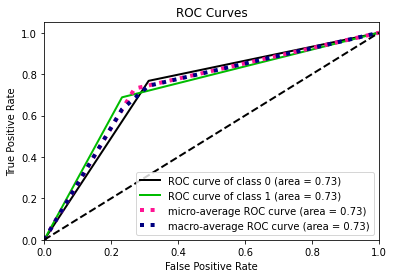

In [483]:
y_test_pred_proba = dt.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.show()

##### Validation score

In [484]:
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X_train, y_train, cv=5)
cross_val_score(dt, X_train, y_train, cv=5)

array([0.69321534, 0.71597633, 0.71597633, 0.72189349, 0.69822485])

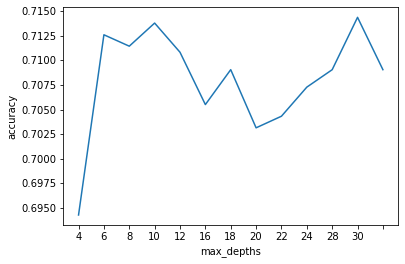

In [485]:
max_depths = [4, 6, 8, 10, 12, 16, 18, 20, 22, 24, 28, 30, None]
scores = list()
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores.append(cross_val_score(dt, X_train, y_train, cv=5).mean())
plt.plot(scores)
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

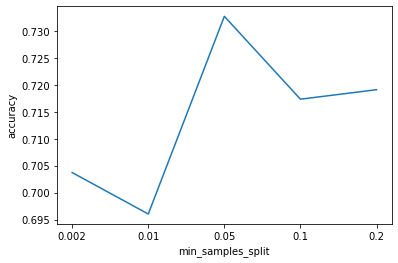

In [486]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
scores = list()
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores.append(cross_val_score(dt, X_train, y_train, cv=5).mean())
plt.plot(scores)
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

##### Iperparametri

In [570]:
# iperparametri
param_grid = {
    "min_samples_split": [0.002, 0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [0.001, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [4, 6, 8, 10, 12, 16, 18, None]
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
    n_jobs=-1,
    refit=True,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [571]:
print("Best params: ", grid.best_params_, "\nBest score: ", grid.best_score_, "\nBest estimator score: ", clf.score(X_test, y_test))

Best params:  {'max_depth': 12, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05} 
Best score:  0.7307460159536402 
Best estimator score:  0.7231404958677686


Il best estimatore è l'accuracy

In [569]:
y_test_pred_new = grid.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_test_pred_new))

#Quindi il best estimator score è l'accuracy

Accuracy:  0.7162534435261708


In [521]:
print(classification_report(y_test, y_test_pred_new))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75       383
           1       0.74      0.63      0.68       343

    accuracy                           0.72       726
   macro avg       0.73      0.72      0.72       726
weighted avg       0.73      0.72      0.72       726



In [522]:
# Rialleniamo il modello sui parametri trovati grazie al grid search
dt_after_grid = DecisionTreeClassifier(max_depth=12, min_samples_leaf=0.01, min_samples_split=0.05)
dt_after_grid.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=0.01,
                       min_samples_split=0.05)

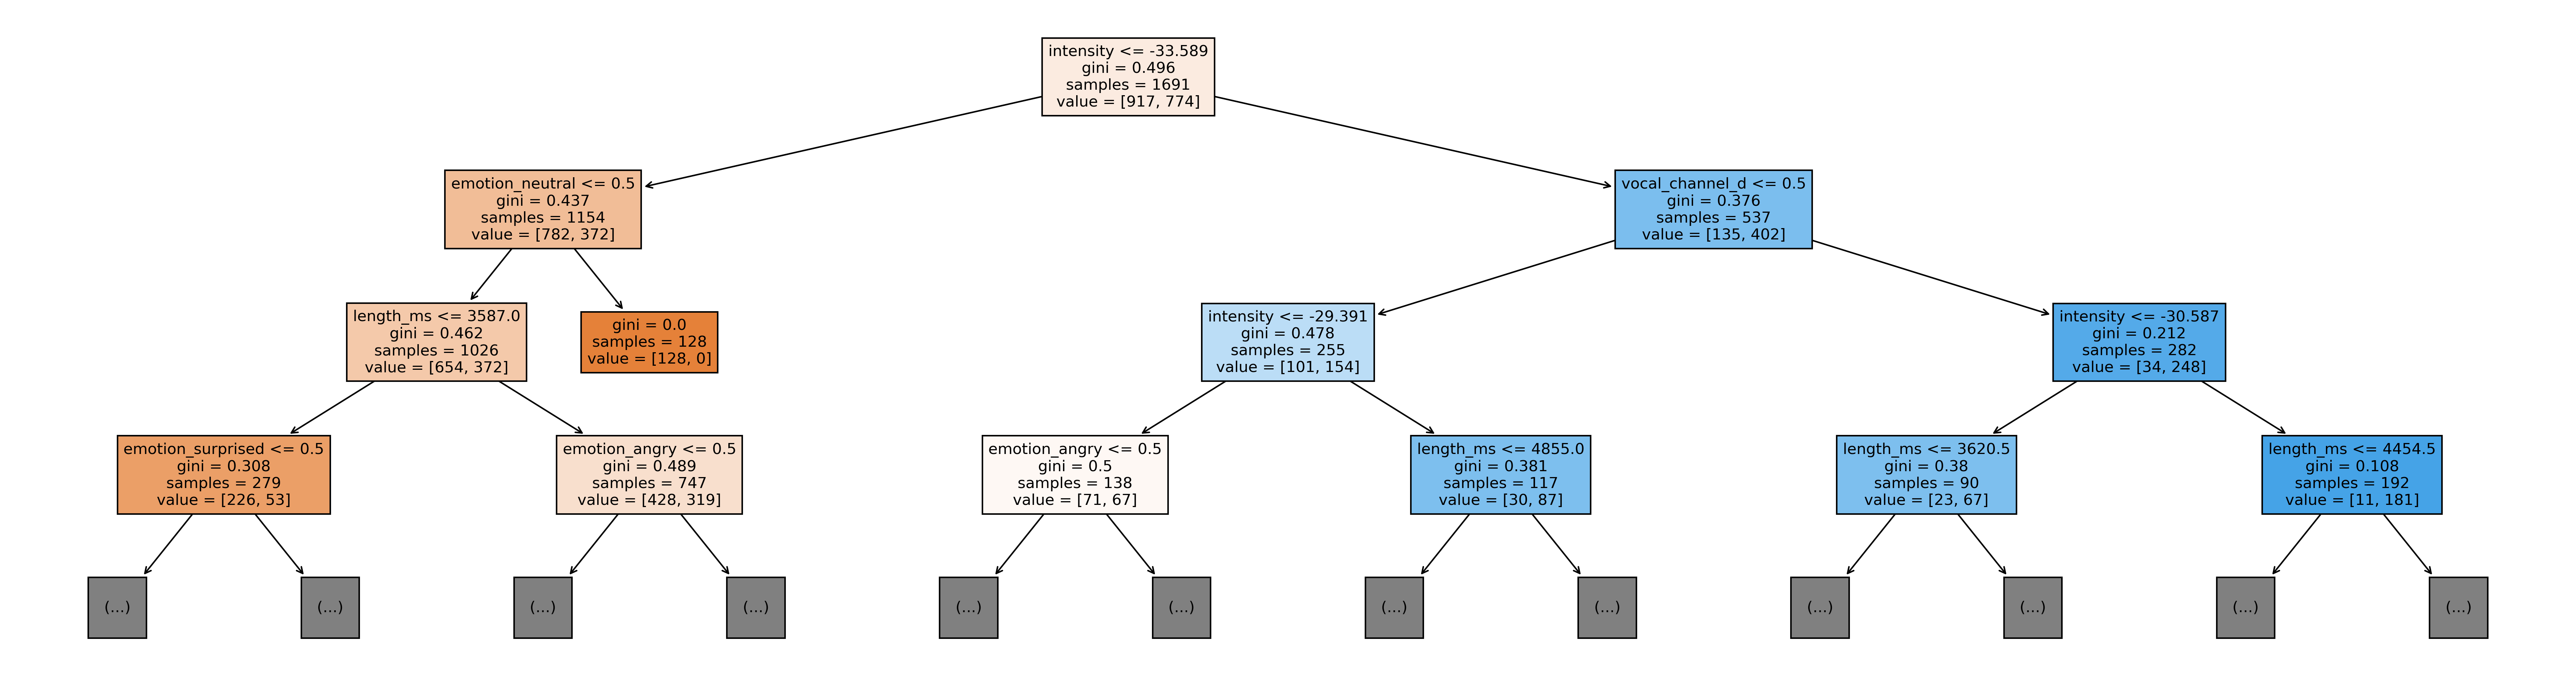

In [500]:
plt.figure(figsize=(30, 8), dpi=300)
plot_tree(dt_after_grid, feature_names=df_classif1.columns, filled=True, max_depth = 3)
plt.show()

In [523]:
# Importanza delle variabili negli split
imp_dict = {attr: dt_after_grid.feature_importances_[i] for i, attr in enumerate(df_classif1.columns)}
imp_dict

{'intensity': 0.49429523340303266,
 'length_ms': 0.15571312813339036,
 'zero_crossings_sum': 0.013351939091446947,
 'emotion_angry': 0.06730622755329933,
 'emotion_calm': 0.015175295054369247,
 'emotion_disgust': 0.0,
 'emotion_fearful': 0.052032108302474976,
 'emotion_happy': 0.0027039671126364473,
 'emotion_neutral': 0.08851099104115323,
 'emotion_sad': 0.03256818843691843,
 'emotion_surprised': 0.018205114749715146,
 'vocal_channel_d': 0.060137807121563136}

##### Confusion Matrix

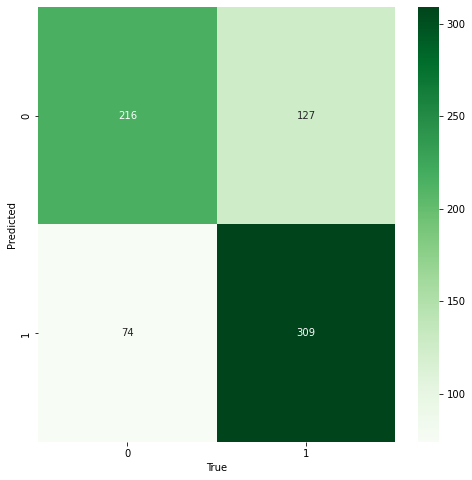

In [524]:
cf = confusion_matrix(y_test, y_test_pred_new, labels=[1,0]) # così stampa TP, FN, FP, TN
plt.figure(figsize=(8, 8))
sns.heatmap(cf, annot=True, cmap="Greens",fmt=".0f")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

##### ROC curve

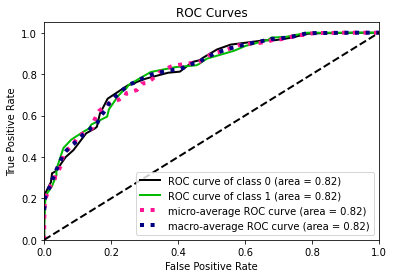

In [525]:
y_test_pred_proba = dt_after_grid.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.show()

# KNN

KNN lavora con le distanze (di ogni punto rispetto ai k più vicini), quindi dobbiamo lavorare con i dataset normalizzati

In [526]:
norm = StandardScaler()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.fit_transform(X_test)

In [527]:
clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='euclidean')

In [528]:
clf.score(X_test_norm, y_test)

0.756198347107438

Applicando il metodo dei KNN otteniamo una precision di 0.756
Proviamo il metodo della grid search per vedere se possiamo aumentarla

In [529]:
param_grid1 = {
    "n_neighbors": np.arange(1, round(math.sqrt(X_train_norm.shape[0]))), #a lezione è stato detto che una buona pratica è usare quella come k
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid1 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid1,
    #cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
    n_jobs=-1,
    refit=True,
)
grid1.fit(X_train_norm, y_train)
clf1 = grid1.best_estimator_

Risultati della grid search:
- best params e vari score
- miglior distanza al variare del numero di k scelti

In [530]:
print("Best params: ", grid1.best_params_, "\nBest score: ", grid1.best_score_, "\nBest estimator score: ", clf1.score(X_test_norm, y_test))

Best params:  {'metric': 'cityblock', 'n_neighbors': 23, 'weights': 'distance'} 
Best score:  0.7634707022045347 
Best estimator score:  0.7658402203856749


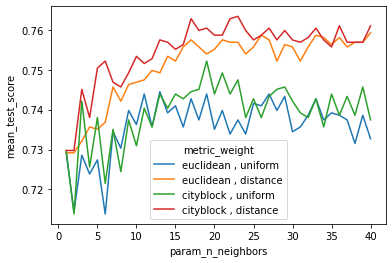

In [531]:
results = pd.DataFrame(grid1.cv_results_)
results["metric_weight"] = results["param_metric"] + " , " + results["param_weights"]
sns.lineplot(data=results, x="param_n_neighbors", y="mean_test_score", hue="metric_weight")
plt.show()

Applichiamo al test set e valutiamo la bontà del modello

In [532]:
y_test_pred_knn_after_grid = grid1.predict(X_test_norm)
print(classification_report(y_test, y_test_pred_knn_after_grid))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       383
           1       0.76      0.74      0.75       343

    accuracy                           0.77       726
   macro avg       0.77      0.76      0.76       726
weighted avg       0.77      0.77      0.77       726



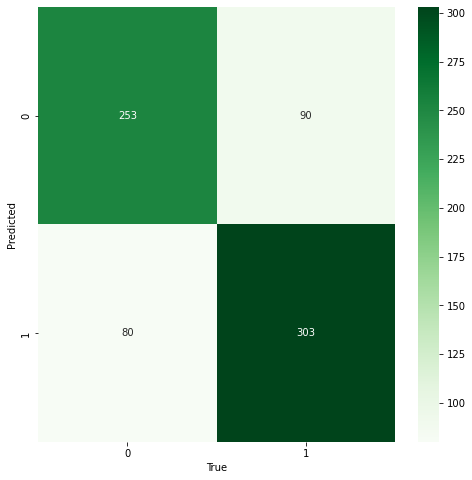

In [533]:
cf = confusion_matrix(y_test, y_test_pred_knn_after_grid, labels=[1,0]) # così stampa TP, FN, FP, TN
plt.figure(figsize=(8, 8))
sns.heatmap(cf, annot=True, cmap="Greens",fmt=".0f")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

il ROC curve si può fare anche nel KNN??? eventualmente eliminare i due blocchi successivi

In [534]:
dt_after_grid_knn = KNeighborsClassifier(metric="cityblock",n_neighbors=23,weights='distance')
dt_after_grid_knn.fit(X_train,y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=23, weights='distance')

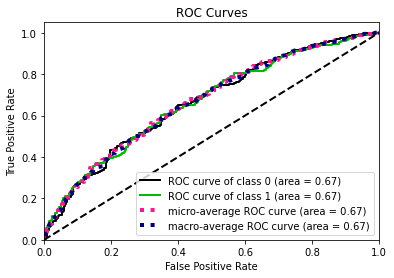

In [535]:
y_test_pred_proba_knn = dt_after_grid_knn.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba_knn)
plt.show()

### Naive Bayes

In [536]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [537]:
y_pred_nb = naive_bayes.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.86      0.38      0.53       383
           1       0.57      0.93      0.71       343

    accuracy                           0.64       726
   macro avg       0.72      0.66      0.62       726
weighted avg       0.73      0.64      0.62       726



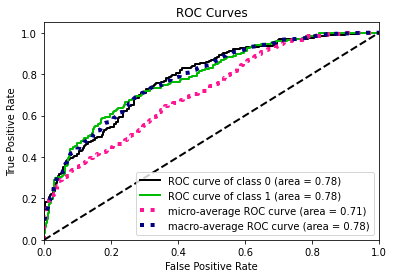

In [538]:
plot_roc(y_test, naive_bayes.predict_proba(X_test))
plt.show()

Conclusioni:
- naive bayes è il peggiore algoritmo
- il KNN sembra l'algoritmo migliore per il nostro set di dati
- fatte varie prove sullo spazio delle feature (raggruppate le emotion, considerate solo le emotion, considerate emotion e vocal channel, emotion e vocal channel e sex)

Nel report possiamo dire che:
- a livello logico la variabile emotional_intensity ci sembra la migliore da utilizzare come variabile target
- abbiamo provato anche con vocal channel, e anche se vengono valori di precision/recall/ecc molto alti (anche fino al 95%), ci sembra strano dato che vocal_channel è stata da noi modificata in quanto conteneva dei missing values

# Pattern mining

I valori continui vanno discretizzati, altrimenti sarebbe impossibile trovare dei pattern frequenti

In [540]:
df_clean["intensity_d"] = pd.qcut(df_clean["intensity"], 4)
df_clean["length_ms_d"] = pd.qcut(df_clean["length_ms"], 4)
df_clean["zero_crossings_sum_d"] = pd.qcut(df_clean["zero_crossings_sum"], 4)

df_clean["intensity_d"] = df_clean["intensity_d"].astype(str) + "_intensity"
df_clean["length_ms_d"] = df_clean["length_ms_d"].astype(str) + "_length"
df_clean["zero_crossings_sum_d"] = df_clean["zero_crossings_sum_d"].astype(str) + "_zero_crossings_sum"

In [545]:
df_clean["emozioni_controllate"] = df_classif["emotion_calm"] + df_classif["emotion_neutral"] + df_classif["emotion_sad"] + df_classif["emotion_happy"]
df_clean["emozioni_forti"] = df_classif["emotion_angry"]  + df_classif["emotion_fearful"] + df_classif["emotion_disgust"] + df_classif["emotion_surprised"] 

In [554]:
df_clean_pm = df_clean[["emotional_intensity","emozioni_forti","vocal_channel_fixed","sex","intensity_d", "length_ms_d", "zero_crossings_sum_d"]]

# usiamo il formato tipico del pattern mining, un dataset con una sola colonna (con tutte le informazioni concatenate)
X = df_clean_pm.values.tolist()

In [555]:
X[0]

['normal',
 'fearful',
 'speech',
 'F',
 '(-37.322, -31.844]_intensity',
 '(3604.0, 4004.0]_length',
 '(14959.0, 30153.0]_zero_crossings_sum']

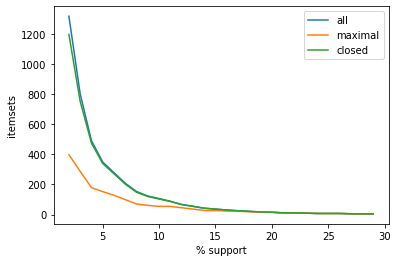

In [556]:
zmin = 2 # minimum number of items per item set
len_all_it = []
len_max_it = []
len_cl_it = []
max_supp = 30
for i in range(2, max_supp):
    all_itemsets = apriori(X, target="s", supp=i, zmin=zmin)
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin)
    len_all_it.append(len(all_itemsets))
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))
    
plt.plot(np.arange(2, max_supp), len_all_it, label="all")
plt.plot(np.arange(2, max_supp), len_max_it, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it, label="closed")
plt.legend()
plt.xlabel("% support")
plt.ylabel("itemsets")
#plt.yticks(range(0,750,50))

plt.show()

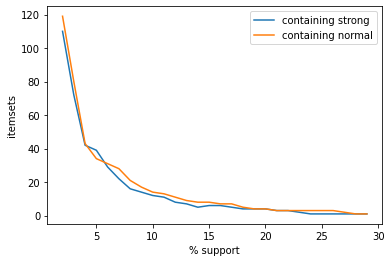

In [557]:
filter_1 = []
filter_2 = []
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=2)
    filter_1.append(len([item for item in max_itemsets if "strong" in item[0]]))
    filter_2.append(len([item for item in max_itemsets if "normal" in item[0]]))

plt.plot(np.arange(2, max_supp), filter_1, label="containing strong")
plt.plot(np.arange(2, max_supp), filter_2, label="containing normal")
plt.legend()
plt.xticks()
plt.xlabel("% support")
plt.ylabel("itemsets")

plt.show()

In [561]:
# Estraiamo tutti i frequent itemsets

supp = 15  # in %
itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support
0,"((4538.0, 6373.0]_length, song)",20.893670
1,"((3604.0, 4004.0]_length, speech)",23.334712
2,"((-31.844, -12.981]_intensity, strong)",20.190319
3,"((14959.0, 30153.0]_zero_crossings_sum, strong)",16.135705
4,"((14959.0, 30153.0]_zero_crossings_sum, F)",20.397187
5,"((10359.0, 12379.0]_zero_crossings_sum, M)",16.177079
6,"((10359.0, 12379.0]_zero_crossings_sum, normal)",15.432354
7,"((10359.0, 12379.0]_zero_crossings_sum, speech)",15.432354
8,"((4720.999, 10359.0]_zero_crossings_sum, M)",18.245759
9,"((4720.999, 10359.0]_zero_crossings_sum, normal)",17.170046


#### Association rules

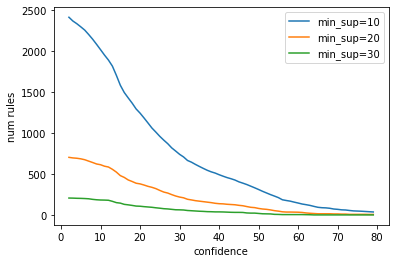

In [559]:
zmin = 2 # minimum number of items per item set
rules_10_app = []
rules_20_app = []
rules_30_app = []
for i in range(2, 80):
    rules_10 = apriori(X, target="r", supp=10, zmin=2, conf=i)
    rules_20 = apriori(X, target="r", supp=20, zmin=2, conf=i)
    rules_30 = apriori(X, target="r", supp=30, zmin=2, conf=i)
    rules_10_app.append(len(rules_10))
    rules_20_app.append(len(rules_20))
    rules_30_app.append(len(rules_30))
    
plt.plot(np.arange(2, 80), rules_10_app, label='min_sup=10')
plt.plot(np.arange(2, 80), rules_20_app, label='min_sup=20')
plt.plot(np.arange(2, 80), rules_30_app, label='min_sup=30')
plt.legend()
plt.xlabel("confidence")
plt.ylabel("num rules")

plt.show()

### Perchè metto supp=20 e ottengo righe anche con supp inferiori?

In [560]:
conf = 60
rules = apriori(X, target="r", supp=20, zmin=2, conf=conf, report="Scl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,%_support,confidence,lift
0,song,"((4538.0, 6373.0]_length,)",20.893670,0.867698,2.312266
4,strong,"((-31.844, -12.981]_intensity,)",20.190319,0.809287,1.751161
7,F,"((14959.0, 30153.0]_zero_crossings_sum,)",20.397187,0.816225,1.662019
14,song,"((4004.0, 4538.0]_length,)",15.432354,0.616529,1.642944
24,speech,"((2935.999, 3604.0]_length,)",26.354986,0.993760,1.590674
3,speech,"((3604.0, 4004.0]_length,)",23.334712,0.957555,1.532722
11,M,"((4720.999, 10359.0]_zero_crossings_sum,)",18.245759,0.728926,1.432368
6,strong,"((14959.0, 30153.0]_zero_crossings_sum,)",16.135705,0.645695,1.397176
17,speech,"((-63.866, -43.454]_intensity,)",21.555647,0.861157,1.378422
5,strong,"((14959.0, 30153.0]_zero_crossings_sum, F)",12.825817,0.628803,1.360624


In [181]:
for r in rules:
    if r[0] == 'strong':
        print(r)

('strong', ('(-31.844, -12.981]_intensity',), 20.190318576748034, 0.8092868988391376, 1.7511606396546067)
('strong', ('(14959.0, 30153.0]_zero_crossings_sum', 'F'), 12.825817128671908, 0.6288032454361054, 1.3606243905273652)
('strong', ('(14959.0, 30153.0]_zero_crossings_sum',), 16.135705419942077, 0.6456953642384106, 1.3971760925373666)


#### Prediction-PatternMining

In [117]:
#left for exercise
#
#using the same test set for classification (w/ random_state):
#predict the target variable with the most interesting rule:
#.... e.g., the most frequent;
#.... e.g., the one w/ max lift
#build a list of prediction, e.g. ['Survived', 'Not Survived', 'Survived']
#evaluate this prediction with precision/recall/confusion matrix etc.

Per fare la prediction uso la seguente regola:
('strong', ('(-31.844, -12.981]_intensity',)

La valutazione deve essere fatta sul test set usato per la classificazione, quindi:
- prendiamo lo spazio delle feature del test set (X_test)
- su questo costruiamo la nuova "prediction" data dal pattern mining (nel nostro caso quando i valori di intensity rientrano in quel gruppo, mettiamo strong come prediction, le altre tutte normal)
- facciamo la valutazione usando l'y_test e y_predicted tramite pm

In [116]:
df_per_pm = pd.DataFrame(X_test)

In [113]:
df_per_pm["emotional_intensity_pm"] = "normal"
df_per_pm.loc[(df_per_pm[0]>-31.844) & (df_per_pm[0]<=-12.981), "emotional_intensity_pm"] = 'strong'
df_per_pm["emotional_intensity_pm"]

0      strong
1      strong
2      normal
3      normal
4      normal
        ...  
721    normal
722    normal
723    normal
724    normal
725    normal
Name: emotional_intensity_pm, Length: 726, dtype: object

In [114]:
print(classification_report(y_test, df_per_pm["emotional_intensity_pm"]))

              precision    recall  f1-score   support

      normal       0.65      0.92      0.76       383
      strong       0.83      0.46      0.59       343

    accuracy                           0.70       726
   macro avg       0.74      0.69      0.68       726
weighted avg       0.74      0.70      0.68       726

